In [24]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
# from tensorboardX import SummaryWriter

# 定义全局变量
modelPath = './model.pkl'
batchSize = 5
numPrint = 1000
# 定义Summary_Writer
# writer = SummaryWriter('./Result')   # 数据存放在这个文件夹
# cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载数据集 (训练集和测试集)
trainset = torchvision.datasets.CIFAR10(root='./Cifar-10', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./Cifar-10', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False)

# 定义神经网络
class Net(nn.Module):  # 训练 ALexNet
    '''
    三层卷积，三层全连接  (应该是5层卷积，由于图片是 32 * 32，且为了效率，这里设成了 3 层)
    '''
    def __init__(self):
        super(Net, self).__init__()
        # 五个卷积层
        self.conv1 = nn.Sequential(  # 输入 32 * 32 * 3
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=1, padding=1),   # (32-3+2)/1+1 = 32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (32-2)/2+1 = 16
        )
        self.conv2 = nn.Sequential(  # 输入 16 * 16 * 6
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1),  # (16-3+2)/1+1 = 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (16-2)/2+1 = 8
        )
        self.conv3 = nn.Sequential(  # 输入 8 * 8 * 16
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # (8-3+2)/1+1 = 8
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (8-2)/2+1 = 4
        )
        self.conv4 = nn.Sequential(  # 输入 4 * 4 * 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), # (4-3+2)/1+1 = 4
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (4-2)/2+1 = 2
        )
        self.conv5 = nn.Sequential(  # 输入 2 * 2 * 128
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),# (2-3+2)/1+1 = 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # (2-2)/2+1 = 1
        )                            # 最后一层卷积层，输出 1 * 1 * 128
        # 全连接层
        self.dense = nn.Sequential(
            nn.Linear(128, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(-1, 128)
        x = self.dense(x)
        return x

# 使用测试数据测试网络
def Accuracy(net):
    correct = 0
    total = 0
    with torch.no_grad():  # 训练集中不需要反向传播
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) # 将输入和目标在每一步都送入GPU
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)  # 返回每一行中最大值的那个元素，且返回其索引
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    return 100.0 * correct / total

# 训练函数
def train(nepochs, net):
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()  # 交叉熵损失
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  # 随机梯度下降
    iter = 0
    num = 1
    # 训练网络
    for epoch in range(nepochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            iter = iter + 1
            # 取数据
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # 将输入和目标在每一步都送入GPU
            # 将梯度置零
            optimizer.zero_grad()
            # 训练
            outputs = net(inputs)
            loss = criterion(outputs, labels).to(device)
            loss.backward()   # 反向传播
            # writer.add_scalar('loss', loss.item(), iter)
            optimizer.step()  # 优化
            # 统计数据
            running_loss += loss.item()
            if i % numPrint == 999:    # 每 batchsize * numPrint 张图片，打印一次
                print('epoch: %d\t batch: %d\t loss: %.6f' % (epoch + 1, i + 1, running_loss / (batchSize*numPrint)))
                running_loss = 0.0
                Accuracy(net)
                # writer.add_scalar('accuracy', Accuracy(), num + 1)
                num = num + 1
    # 保存模型
    torch.save(net, './model.pkl')

Files already downloaded and verified
Files already downloaded and verified


In [25]:
net = Net().to(device)
# 如果模型存在，加载模型
if os.path.exists(modelPath):
    print('model exits')
    net = torch.load(modelPath)
    print('model loaded')
else:
    print('model not exits')
print('Training Started')
train(10, net)
# writer.close()
print('Training Finished')

# references: https://blog.csdn.net/rocketeerLi/article/details/92242655

model not exits
Training Started
epoch: 1	 batch: 1000	 loss: 0.460479
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 2000	 loss: 0.460731
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 3000	 loss: 0.460622
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 4000	 loss: 0.460618
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 5000	 loss: 0.460667
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 6000	 loss: 0.460717
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 7000	 loss: 0.460623
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 8000	 loss: 0.460602
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 9000	 loss: 0.460542
Accuracy of the network on the 10000 test images: 10 %
epoch: 1	 batch: 10000	 loss: 0.460667
Accuracy of the network on the 10000 test images: 10 %
epoch: 2	 batch: 1000	 loss: 0.46061

Global pruning

In [26]:
import torch
from torch import nn
import torch.nn.utils.prune as prune

def prune_alex_net(net,amount):
  parameters_to_prune = (
      (net.conv1[0], 'weight'),
      (net.conv2[0], 'weight'),
      (net.conv3[0], 'weight'),
      (net.conv4[0], 'weight'),
      (net.conv5[0], 'weight'),
      (net.dense[0], 'weight'),
      (net.dense[2], 'weight'),
      (net.dense[4], 'weight'),
  )

  prune.global_unstructured(
      parameters_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=amount,
  )
  return net

In [27]:
def print_alex_net_prunning_summary(net):
  print(
      "Sparsity in conv1.weight: {:.2f}%".format(
          100. * float(torch.sum(net.conv1[0].weight == 0))
          / float(net.conv1[0].weight.nelement())
      )
  )
  print(
      "Sparsity in conv2.weight: {:.2f}%".format(
          100. * float(torch.sum(net.conv2[0].weight == 0))
          / float(net.conv2[0].weight.nelement())
      )
  )
  print(
      "Sparsity in conv3.weight: {:.2f}%".format(
          100. * float(torch.sum(net.conv3[0].weight == 0))
          / float(net.conv3[0].weight.nelement())
      )
  )
  print(
      "Sparsity in conv4.weight: {:.2f}%".format(
          100. * float(torch.sum(net.conv4[0].weight == 0))
          / float(net.conv4[0].weight.nelement())
      )
  )
  print(
      "Sparsity in conv5.weight: {:.2f}%".format(
          100. * float(torch.sum(net.conv5[0].weight == 0))
          / float(net.conv5[0].weight.nelement())
      )
  )
  print(
      "Sparsity in desnse.weight: {:.2f}%".format(
          100. * float(torch.sum(net.dense[0].weight == 0))
          / float(net.dense[0].weight.nelement())
      )
  )
  print(
      "Sparsity in desnse.weight: {:.2f}%".format(
          100. * float(torch.sum(net.dense[0].weight == 0))
          / float(net.dense[2].weight.nelement())
      )
  )
  print(
      "Sparsity in desnse.weight: {:.2f}%".format(
          100. * float(torch.sum(net.dense[0].weight == 0))
          / float(net.dense[4].weight.nelement())
      )
  )
  print(
      "Global sparsity: {:.2f}%".format(
          100. * float(
              torch.sum(net.conv1[0].weight == 0)
              + torch.sum(net.conv2[0].weight == 0)
              + torch.sum(net.conv3[0].weight == 0)
              + torch.sum(net.conv4[0].weight == 0)
              + torch.sum(net.conv5[0].weight == 0)
              + torch.sum(net.dense[0].weight == 0)
              + torch.sum(net.dense[2].weight == 0)
              + torch.sum(net.dense[4].weight == 0)
          )
          / float(
              net.conv1[0].weight.nelement()
              + net.conv2[0].weight.nelement()
              + net.conv3[0].weight.nelement()
              + net.conv4[0].weight.nelement()
              + net.conv5[0].weight.nelement()
              + net.dense[0].weight.nelement()
              + net.dense[2].weight.nelement()
              + net.dense[4].weight.nelement()
          )
      )
  )

Accuracy of the network on the 10000 test images: 64 %
prunning_net_20_perce
Sparsity in conv1.weight: 3.09%
Sparsity in conv2.weight: 4.63%
Sparsity in conv3.weight: 8.70%
Sparsity in conv4.weight: 12.59%
Sparsity in conv5.weight: 25.24%
Sparsity in desnse.weight: 13.53%
Sparsity in desnse.weight: 20.62%
Sparsity in desnse.weight: 247.38%
Global sparsity: 20.00%
Accuracy of the network on the 10000 test images: 64 %
prunning_net_50_perce
Sparsity in conv1.weight: 5.56%
Sparsity in conv2.weight: 12.27%
Sparsity in conv3.weight: 22.61%
Sparsity in conv4.weight: 33.25%
Sparsity in conv5.weight: 62.10%
Sparsity in desnse.weight: 34.80%
Sparsity in desnse.weight: 53.04%
Sparsity in desnse.weight: 636.43%
Global sparsity: 50.00%
Accuracy of the network on the 10000 test images: 63 %
prunning_net_70_perce
Sparsity in conv1.weight: 6.79%
Sparsity in conv2.weight: 20.95%
Sparsity in conv3.weight: 35.72%
Sparsity in conv4.weight: 51.02%
Sparsity in conv5.weight: 83.22%
Sparsity in desnse.weight

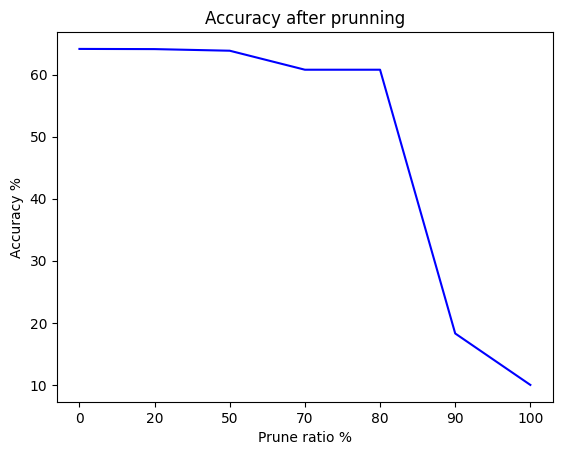

In [34]:
import copy
import matplotlib.pyplot as plt

x = ['0', '20', '50', '70', '80', '90', '100']
y = [Accuracy(net), ]

print('prunning_net_20_perce')
prunning_net_20_perce = copy.deepcopy(net)
prune_alex_net(prunning_net_20_perce, 0.2)
print_alex_net_prunning_summary(prunning_net_20_perce)
y.append(Accuracy(prunning_net_20_perce))
print('prunning_net_50_perce')
prunning_net_50_perce = copy.deepcopy(net)
prune_alex_net(prunning_net_50_perce, 0.5)
print_alex_net_prunning_summary(prunning_net_50_perce)
y.append(Accuracy(prunning_net_50_perce))
print('prunning_net_70_perce')
prunning_net_70_perce = copy.deepcopy(net)
prune_alex_net(prunning_net_70_perce, 0.7)
print_alex_net_prunning_summary(prunning_net_70_perce)
y.append(Accuracy(prunning_net_70_perce))
print('prunning_net_80_perce')
prunning_net_80_perce = copy.deepcopy(net)
prune_alex_net(prunning_net_80_perce, 0.7)
print_alex_net_prunning_summary(prunning_net_80_perce)
y.append(Accuracy(prunning_net_80_perce))
print('prunning_net_90_perce')
prunning_net_90_perce = copy.deepcopy(net)
prune_alex_net(prunning_net_90_perce, 0.9)
print_alex_net_prunning_summary(prunning_net_90_perce)
y.append(Accuracy(prunning_net_90_perce))
print('prunning_net_100_perce')
prunning_net_100_perce = copy.deepcopy(net)
prune_alex_net(prunning_net_100_perce, 1.0)
print_alex_net_prunning_summary(prunning_net_100_perce)
y.append(Accuracy(prunning_net_100_perce))

plt.plot(x, y, color='b')
plt.xlabel('Prune ratio %') # 設定x軸標題
plt.ylabel('Accuracy %') # 設定x軸標題
plt.title('Accuracy after prunning') # 設定圖表標題
plt.show()